# Data Augmentation for Computer Vision with PyTorch: Image Segmentation

Augmenting data for image segmentation is more complicated than for image classification since we have to augment not only the input image but also the segmentation mask.

To do so, we define a dataset class that will receive two directories, one containing the input images and other with the segmentation masks. The file names must match (or at least be in the same alphabetical order).

The dataset constructor also receives two augmentation operations that will be applied to the input image and the segmentation mask. We need two separate augmentation operations since some augmentation techniques (e.g., color jittering) don't make sense for segmentation masks.

Also, we need a way of guaranteeing that the geometric changes in the original image also reflect in the mask. For that, we will set the same seed for the RNG for both operations. We also provide an optional argument that may receive a function to set additional seeds (from external libraries, for instance).

In [ ]:
!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
!pip install git+https://github.com/aleju/imgaug

In [1]:
import numpy as np
from skimage.io import imshow, imread
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 10

def show(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

In [2]:
import os
import random

import torch
import torch.utils.data as data

from PIL import Image

class SegmentationDataset(data.Dataset):
    IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']

    @staticmethod
    def _isimage(image, ends):
        return any(image.endswith(end) for end in ends)
    
    @staticmethod
    def _load_input_image(path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    
    @staticmethod
    def _load_target_image(path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')
            
    def __init__(self, input_root, target_root, transform_input=None,
                 transform_target=None, seed_fn=None):
        assert bool(transform_input) == bool(transform_target)
        
        self.input_root = input_root
        self.target_root = target_root
        self.transform_input = transform_input
        self.transform_target = transform_target
        self.seed_fn = seed_fn
                
        self.input_ids = sorted(img for img in os.listdir(self.input_root)
                                if self._isimage(img, self.IMG_EXTENSIONS))
        
        self.target_ids = sorted(img for img in os.listdir(self.target_root)
                                 if self._isimage(img, self.IMG_EXTENSIONS))
        
        assert(len(self.input_ids) == len(self.target_ids))
    
    def _set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)
        if self.seed_fn:
            self.seed_fn(seed)
        
    def __getitem__(self, idx):
        input_img = self._load_input_image(
            os.path.join(self.input_root, self.input_ids[idx]))
        target_img = self._load_target_image(
            os.path.join(self.target_root, self.target_ids[idx]))
        
        if self.transform_input:
            seed = random.randint(0, 2**32)
            self._set_seed(seed)
            input_img = self.transform_input(input_img)
            self._set_seed(seed)
            target_img = self.transform_target(target_img)
            
        return input_img, target_img, self.input_ids[idx]
        
    def __len__(self):
        return len(self.input_ids)

Let's try with the default torchvision augmentations.

Note that we need to perform the geometric augmentations first because they will be the first transformations that will use the seed for the RNG. If, in the input image, we use a different augmentation order, the random numbers for the next augmentations will be different, making a mask that does not correspond to the augmented input image.

In [3]:
geometric_augs = [
    transforms.RandomResizedCrop(299),
    transforms.RandomRotation(45),
]

color_augs = [
    transforms.ColorJitter(hue=0.05, saturation=0.4)
]

def make_tfs(augs):
    return transforms.Compose(augs + [transforms.ToTensor()])

tfs = transforms.Compose(geometric_augs)

ds = SegmentationDataset('../data/segmentation/input/', '../data/segmentation/masks/',
                         transform_input=make_tfs(geometric_augs + color_augs),
                         transform_target=make_tfs(geometric_augs))

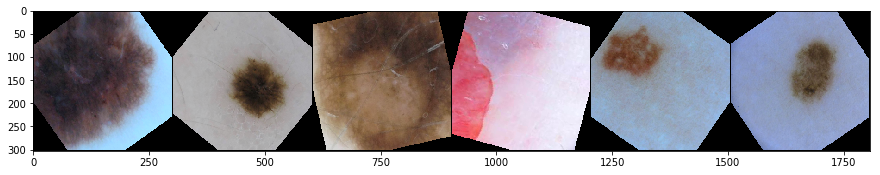

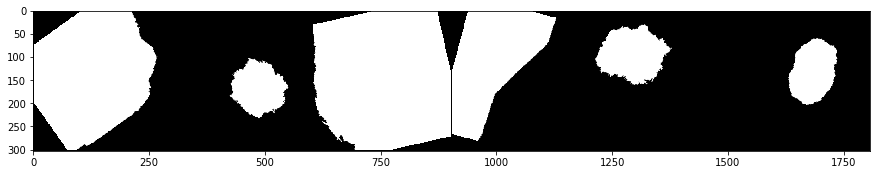

In [4]:
imgs = [ds[i] for i in range(6)]

show(torchvision.utils.make_grid(torch.stack([img[0] for img in imgs])))
show(torchvision.utils.make_grid(torch.stack([img[1] for img in imgs])))

Now let's use an external library: [imgaug](https://github.com/aleju/imgaug).

We need to pass a function that sets the seed for imgaug to the `seed_fn` argument.

In [5]:
from imgaug import augmenters as iaa
import imgaug as ia

In [6]:
geometric_augs = [
        iaa.Scale((299, 299)),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-45, 45),
                   translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
]
color_augs = [
    iaa.AddToHueAndSaturation((-10, 10))
]

def iaug_to_pytorch(augs):
    return transforms.Compose([
        lambda x: np.array(x),
        lambda x: iaa.Sequential(augs).augment_image(x),
        lambda x: Image.fromarray(x),
        transforms.ToTensor(),
    ])

ds2 = SegmentationDataset('../data/segmentation/input/', '../data/segmentation/masks/',
                          transform_input=iaug_to_pytorch(geometric_augs + color_augs),
                          transform_target=iaug_to_pytorch(geometric_augs),
                          seed_fn=lambda x: ia.seed(x % 2**32))

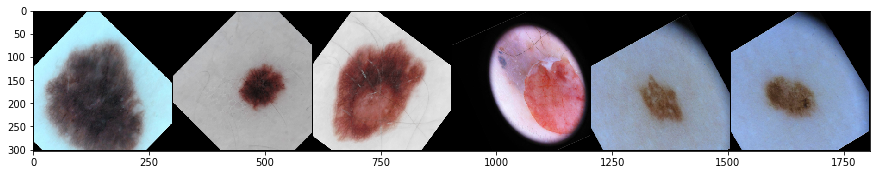

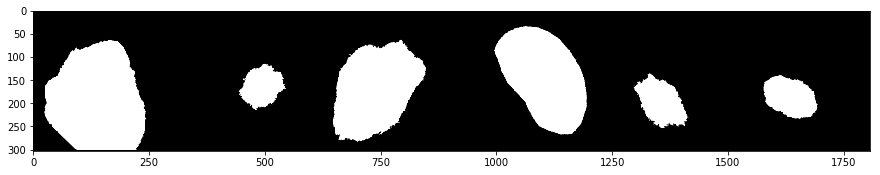

In [7]:
imgs = [ds2[i] for i in range(6)]

show(torchvision.utils.make_grid(torch.stack([img[0] for img in imgs])))
show(torchvision.utils.make_grid(torch.stack([img[1] for img in imgs])))

This solution seems to work well, but one has to be very careful when ordering the transforms.

Let's modify the `SegmentationDataset` class to receive imgaug augmentations only.

Now we will read the images with `skimage.io.imread` since imgaug works with numpy arrays.

We will use hooks (as explained [here](https://github.com/aleju/imgaug#examples)) to dynamically disable some augmentations for the segmentation mask. We define only one transformation argument and an additional `input_only` argument that will receive a list of augmentors names that will be applied for input images only.

In [8]:
class SegmentationDatasetImgaug(data.Dataset):
    IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']

    @staticmethod
    def _isimage(image, ends):
        return any(image.endswith(end) for end in ends)
    
    @staticmethod
    def _load_input_image(path):
        return imread(path)
    
    @staticmethod
    def _load_target_image(path):
        return imread(path, as_gray=True)[..., np.newaxis]
            
    def __init__(self, input_root, target_root, transform=None, input_only=None):
        self.input_root = input_root
        self.target_root = target_root
        self.transform = transform
        self.input_only = input_only
                
        self.input_ids = sorted(img for img in os.listdir(self.input_root)
                                if self._isimage(img, self.IMG_EXTENSIONS))
        
        self.target_ids = sorted(img for img in os.listdir(self.target_root)
                                 if self._isimage(img, self.IMG_EXTENSIONS))
        
        assert(len(self.input_ids) == len(self.target_ids))
        
    def _activator_masks(self, images, augmenter, parents, default):
        if self.input_only and augmenter.name in self.input_only:
            return False
        else:
            return default
    
    def __getitem__(self, idx):
        input_img = self._load_input_image(
            os.path.join(self.input_root, self.input_ids[idx]))
        target_img = self._load_target_image(
            os.path.join(self.target_root, self.target_ids[idx]))
        
        if self.transform:
            det_tf = self.transform.to_deterministic()
            input_img = det_tf.augment_image(input_img)
            target_img = det_tf.augment_image(
                target_img,
                hooks=ia.HooksImages(activator=self._activator_masks))
            
        to_tensor = transforms.ToTensor()
        input_img = to_tensor(input_img)
        target_img = to_tensor(target_img)
            
        return input_img, target_img, self.input_ids[idx]
        
    def __len__(self):
        return len(self.input_ids)

In [9]:
augs = iaa.Sequential([
    iaa.Scale((299, 299)),
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-45, 45),
               translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
    iaa.Add((-40, 40), per_channel=0.5, name="color-jitter")
])


ds3 = SegmentationDatasetImgaug(
    '../data/segmentation/input/', '../data/segmentation/masks/',
    transform=augs,
    input_only=['color-jitter']
)

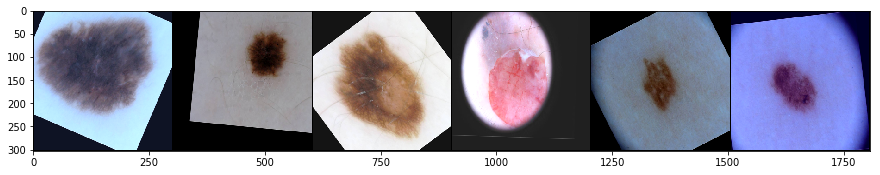

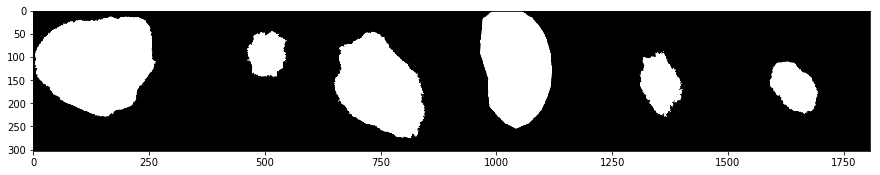

In [10]:
imgs = [ds3[i] for i in range(6)]

show(torchvision.utils.make_grid(torch.stack([img[0] for img in imgs])))
show(torchvision.utils.make_grid(torch.stack([img[1] for img in imgs])))

This solution is more elegant than the previous ones. We can now add different augmentations and apply some of them to the input image only.